In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
from diagnostics_class import Diagnostics

In [3]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# LED OFF TRIALS
df = df[  df['LED_trial'] == 0 ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

In [4]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [11]:
df.loc[:, 'rt'] = df['timed_fix']
df.loc[:, 't_stim'] = df['intended_fix']

In [16]:
df.loc[:, 'rt_wrt_stim'] = df['rt'] - df['t_stim']

In [17]:
df_valid = df[ df['rt_wrt_stim'] > 0 ]

In [18]:
T_peak = 0.21

df_valid_left = df_valid[df_valid['rt_wrt_stim'] < T_peak]
df_valid_right = df_valid[df_valid['rt_wrt_stim'] > T_peak]

In [33]:
len(df_valid_left), len(df_valid_right)

(30129, 24197)

In [22]:
# stim wise RTDs
all_ABL = np.sort(df['ABL'].unique())
all_ILD = np.sort(df['ILD'].unique())
all_ILD = all_ILD[all_ILD > 0]
all_ILD

array([ 1.,  2.,  4.,  8., 16.])

In [47]:
q = df_valid_left[df_valid_left['ABL'] == 20]
len(q)

8046

In [49]:
len(q[q['ILD'].isin([1,-1])])

1149

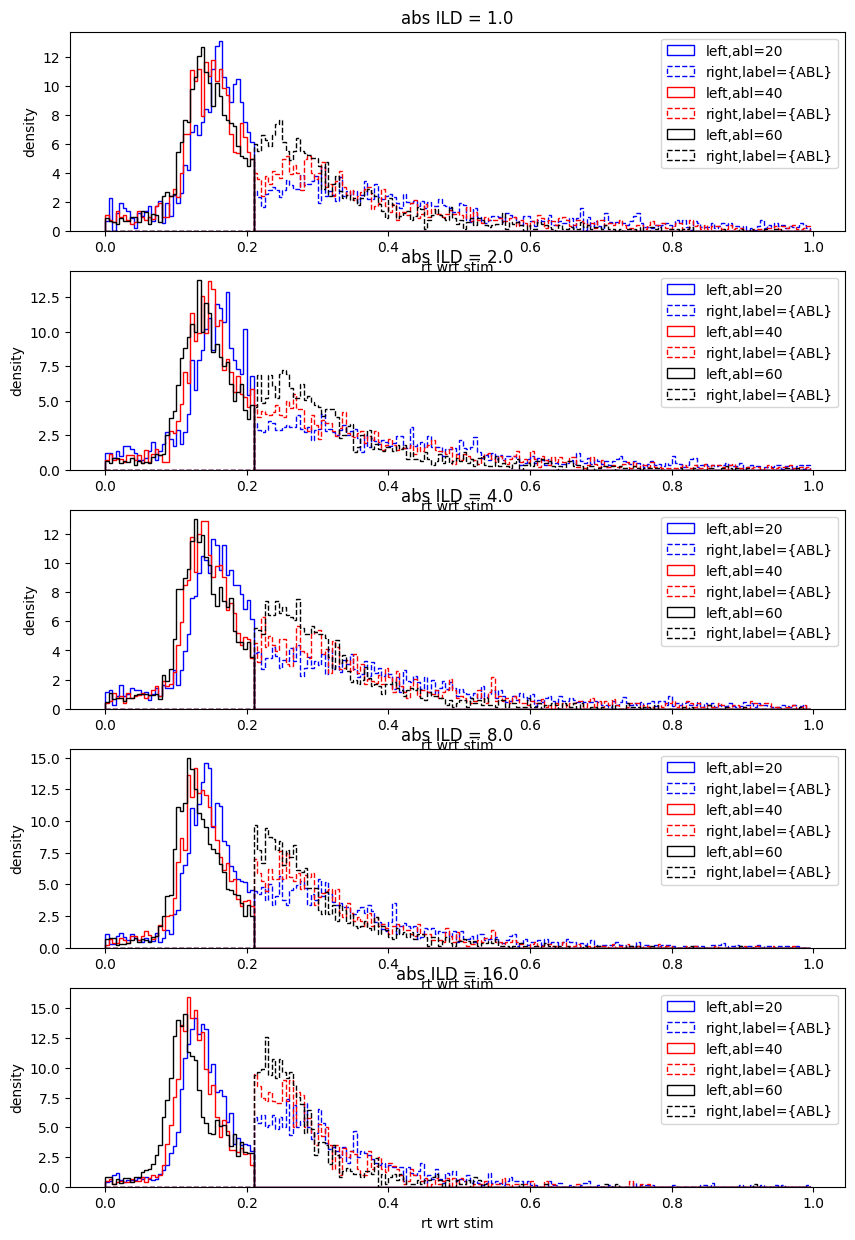

In [55]:
ABL_colors = {20: 'b', 40: 'r', 60: 'k'}
bins = np.arange(0, 1, 0.005)
f = 1
plt.figure(figsize=(10,15))

for ILD in all_ILD:
    plt.subplot(len(all_ILD), 1, f)
    for ABL in all_ABL:
        left_rt = df_valid_left[ (df_valid_left['ABL'] == ABL) & (df_valid_left['ILD'].isin([ILD, -ILD])) ]['rt_wrt_stim']
        right_rt = df_valid_right[ (df_valid_right['ABL'] == ABL) & (df_valid_right['ILD'].isin([ILD, -ILD])) ]['rt_wrt_stim']

        plt.hist(left_rt, bins=bins, density=True, label=f'left,abl={ABL}', color=ABL_colors[ABL], histtype='step')
        plt.hist(right_rt, bins=bins, density=True, label='right,label={ABL}', color=ABL_colors[ABL], histtype='step', linestyle='--')

    plt.legend()
    plt.xlabel('rt wrt stim')
    plt.ylabel('density')
    plt.title(f'abs ILD = {ILD}')
    f += 1
        



# other diagnostics

In [56]:
df_valid_left_diag = Diagnostics(df_valid_left)
df_valid_right_diag = Diagnostics(df_valid_right)

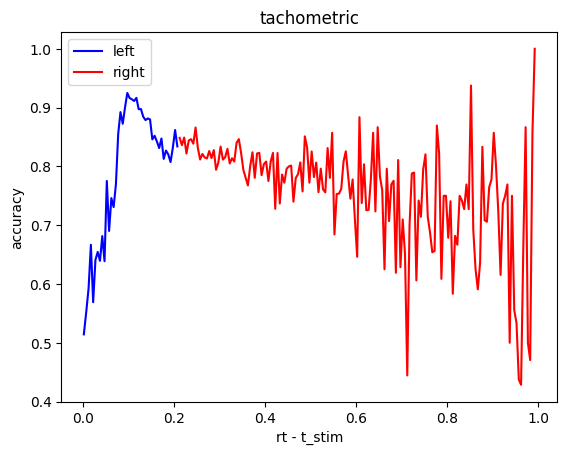

In [87]:
bins = np.arange(0, 1, 0.005)
x,y = df_valid_left_diag.plot_tacho(bins)
plt.plot(x,y, label='left', color='b');
x,y = df_valid_right_diag.plot_tacho(bins)
plt.plot(x,y, label='right', color='r')

plt.xlabel('rt - t_stim')
plt.ylabel('accuracy')
plt.title('tachometric');
plt.legend();

# chronometric

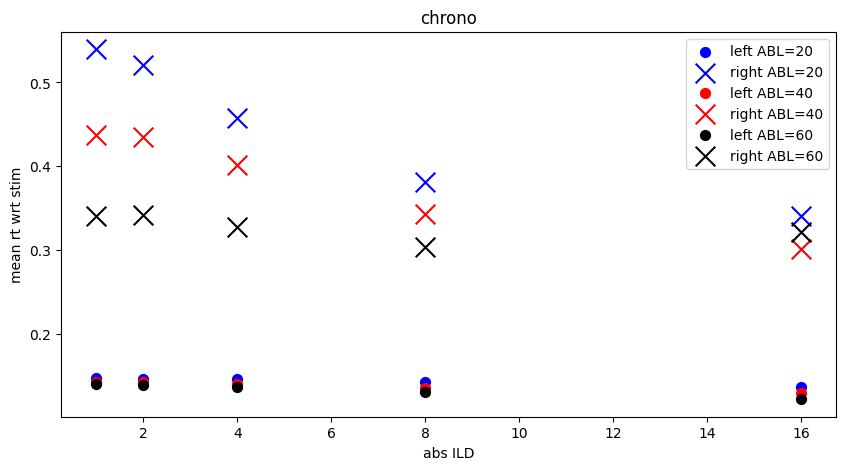

In [66]:
x,left_chrono = df_valid_left_diag.plot_chrono()
x, right_chrono = df_valid_right_diag.plot_chrono()
plt.figure(figsize=(10, 5))
for ABL in all_ABL:
    plt.scatter(x, left_chrono[ABL], label=f'left ABL={ABL}', color=ABL_colors[ABL], s=200, marker='.')
    plt.scatter(x, right_chrono[ABL], label=f'right ABL={ABL}', color=ABL_colors[ABL], s=200, marker='x')

plt.xlabel('abs ILD')
plt.ylabel('mean rt wrt stim')
plt.title('chrono')
plt.legend()



# psyychometric

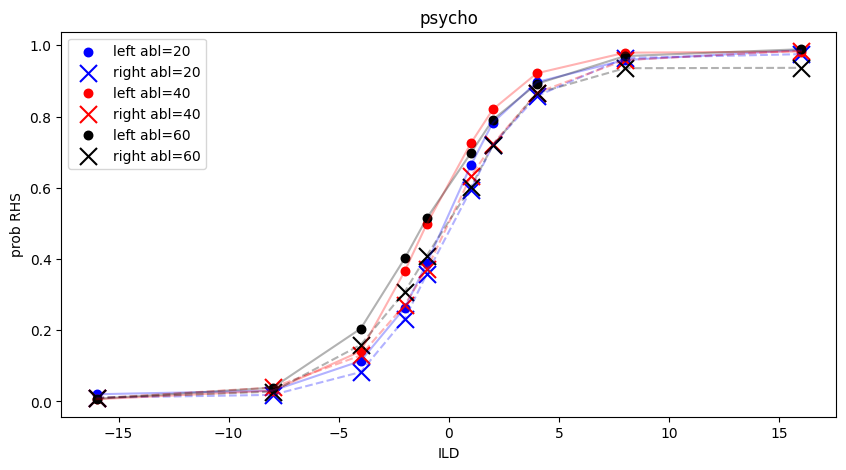

In [85]:
ABL_colors = {20: 'b', 40: 'r', 60: 'k'}

left_psycho = df_valid_left_diag.plot_psycho()
right_psycho = df_valid_right_diag.plot_psycho()
plt.figure(figsize=(10, 5))
for ABL in all_ABL:
    plt.scatter(ILD_arr, left_psycho[ABL], marker='.', s=150, color=ABL_colors[ABL], label=f'left abl={ABL}')
    plt.plot(ILD_arr, left_psycho[ABL], alpha=0.3, color=ABL_colors[ABL])
    
    plt.scatter(ILD_arr, right_psycho[ABL], marker='x', s=150, color= ABL_colors[ABL], label=f'right abl={ABL}')
    plt.plot(ILD_arr, right_psycho[ABL], alpha=0.3, ls='--', color=ABL_colors[ABL])

plt.xlabel('ILD')
plt.ylabel('prob RHS')
plt.title('psycho')
plt.legend();

# quantiles

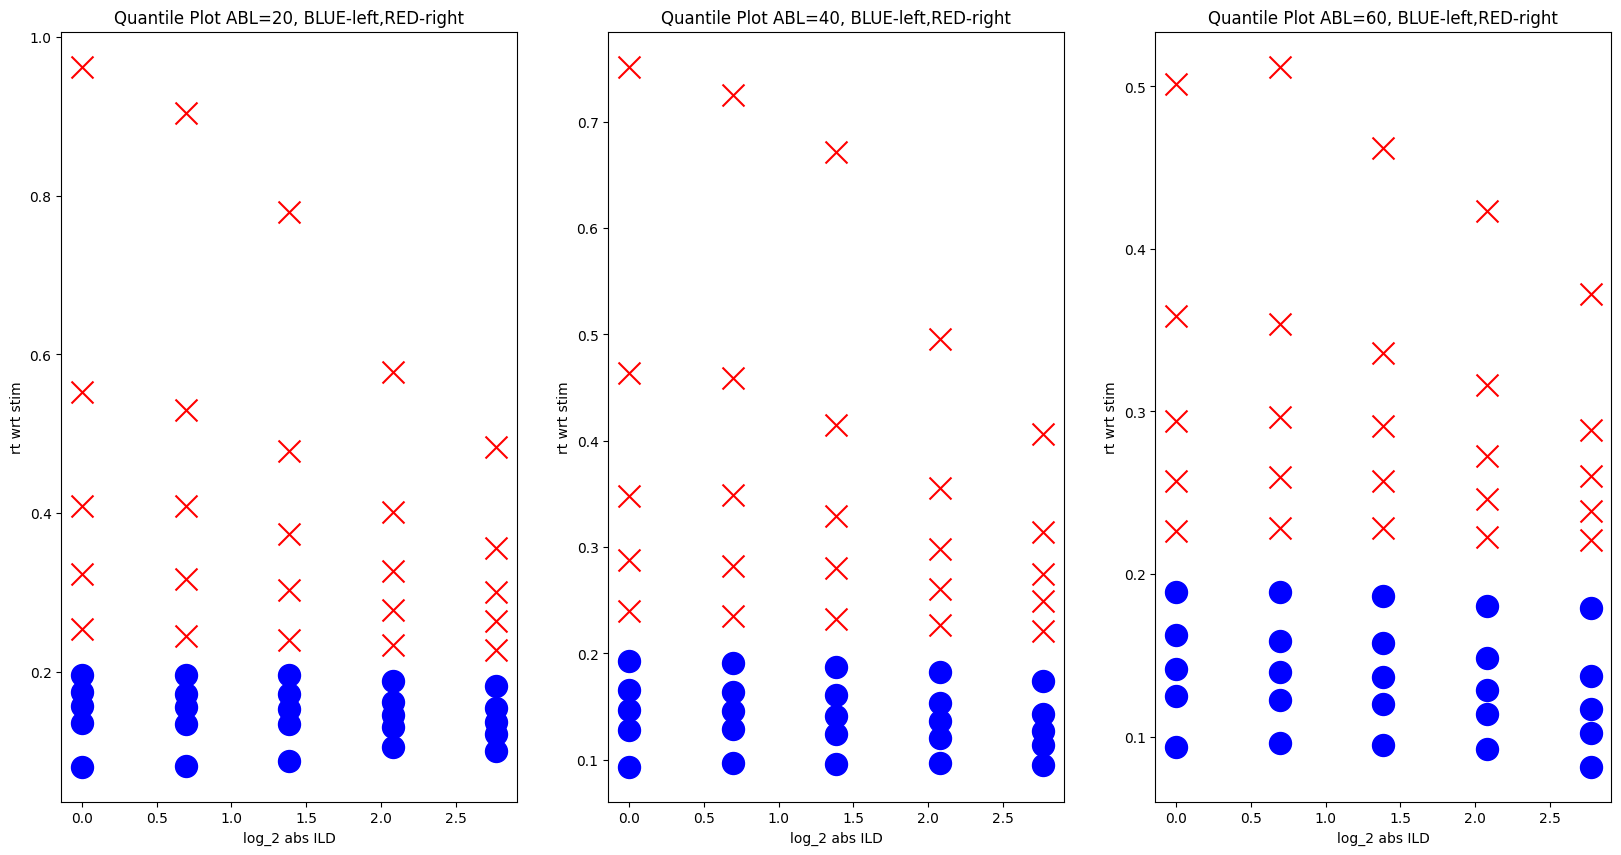

In [84]:
left_quantile = df_valid_left_diag.plot_quantile()
right_quantile = df_valid_right_diag.plot_quantile()

plt.figure(figsize=(20, 10))
for idx, ABL in enumerate(ABL_arr):
    plt.subplot(1,3,idx+1)
    for ild in all_ILD:
        plt.scatter(np.log(ild*np.ones_like(left_quantile[ABL][ild])), left_quantile[ABL][ild], color='b', s=250)
        plt.scatter(np.log(ild*np.ones_like(right_quantile[ABL][ild])), right_quantile[ABL][ild], marker='x', color='r', s=250)
    plt.title(f'Quantile Plot ABL={ABL}, BLUE-left,RED-right')
    plt.xlabel('log_2 abs ILD')
    plt.ylabel('rt wrt stim')